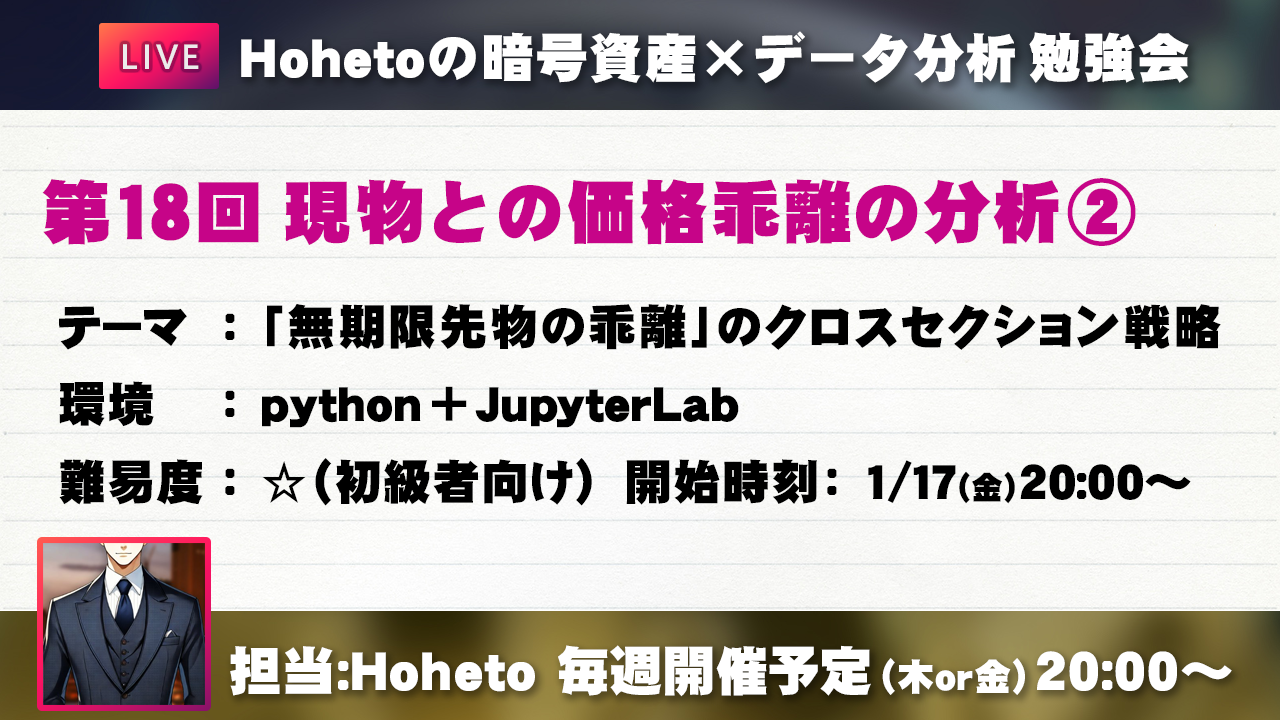

In [1]:
from IPython.display import Image

Image('./images/18_00.png')

# Hoheto勉強会 第18回 現物との価格乖離の分析　クロスセクション編

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- 第13回目の勉強会で、「無期限先物と現物との乖離」を利用した戦略を作成しました。
- 今回は、この指標を複数のアルトコインに展開して、クロスセクションの戦略を作成してみます。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆1つ。

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# おさらい　現物とデリバティブとの価格乖離とは

- 現物取引について
  - 現物とはビットコインのブロックチェーンに記録されているデータそのもの。
- デリバティブ取引について
  - デリバティブとは派生商品のこと。
  - ビットコイン価格に基づいて構築された様々な金融商品。

- なぜデリバティブが使われるか？
  - レバレッジをかけた取引（資金効率アップ）
  - ヘッジ取引
  - ロングやショート、オプションなどを含めた戦略構築

- 現物との価格乖離とはなにか？
  - 現物と比べてデリバティブが買われると、デリバティブ価格＞現物価格となり、上乖離する。
  - 現物と比べてデリバティブが売られると、デリバティブ価格＜現物価格となり、下乖離する。

- なぜ、このような現象が起きるのか？
  - 一般的に、
  - 強気な上昇相場ではレバレッジをかけたロングポジションが増える or ヘッジショート解消などにより、デリバティブが上乖離する。
  - 弱気な下落相場ではロングポジションの解消 or ヘッジショート or レバレッジをかけたショートポジションなどにより、デリバティブが下乖離する。

# クロスセクションとは

- 「ある特定の時点」における複数の資産のデータを比較・分析する手法。
- 時系列分析（過去の推移を見る方法）とは異なり、同時点での複数の投資対象の比較に焦点を当てる。
- 相対的な動きを把握するのに適している。

# データ取得

## 価格データ取得

- 使用データは、
  - Binanceのアルトコイン先物
  - Binanceのアルトコイン現物
- 期間は2024年6月1日～2024年12月31日です。
- 今回は4時間足を利用します。
  - 本当は日足でデモをしたかったが、芳しい結果が出なかったため。
  - アルトコイン多数、かつ4時間足なので、API制限の都合で短めの期間としています。

In [5]:
from_date = '2024-06-01'
to_date = '2024-12-31'

In [6]:
apis = {
    'binance_perp': ccxt.binanceusdm(),
    'binance_spot': ccxt.binance(),
}

- ccxtを利用してOHLCVを取得する関数

In [7]:
from dateutil import parser

def fetch_ohlcv(exchange, symbol, from_date, to_date, timeframe):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    start_time = from_time
    limit = 1000
    ohlcv_list = []
    while True:
        if type(exchange) == str:
            api = apis[exchange]
        else:
            api = exchange
        ohlcv = api.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time, limit=limit)
        if len(ohlcv) == 0:
            break
        ohlcv_list += ohlcv
        start_time = ohlcv[-1][0] + 1
        # print(f'{datetime.fromtimestamp(ohlcv[-1][0] / 1000)}')
        if start_time > to_time:
            break
        time.sleep(1)
    df = pd.DataFrame(ohlcv_list)
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df['ror'] = (df['close'] - df['open']) / df['open']
    df.columns = [f'{exchange}_{column}' for column in df.columns]
    df = df[from_date:to_date]
    return df

In [8]:
fetch_ohlcv('binance_perp', 'BTCUSDT', from_date, to_date, '1d')

,binance_perp_open,binance_perp_high,binance_perp_low,binance_perp_close,binance_perp_volume,binance_perp_ror
timestamp,,,,,,
2024-06-01 00:00:00+00:00,67577.9,67936.0,67480.0,67799.2,50943.058,0.003275
2024-06-02 00:00:00+00:00,67799.2,68545.9,67296.3,67805.9,102194.718,0.000099
2024-06-03 00:00:00+00:00,67805.9,70372.9,67642.6,68851.4,227676.930,0.015419
2024-06-04 00:00:00+00:00,68851.3,71146.4,68595.5,70580.0,216100.016,0.025108
2024-06-05 00:00:00+00:00,70580.0,71824.4,70423.6,71133.3,203992.034,0.007839
...,...,...,...,...,...,...
2024-12-27 00:00:00+00:00,95750.9,97564.5,93440.0,94258.9,206008.243,-0.015582
2024-12-28 00:00:00+00:00,94258.9,95700.0,94100.0,95259.1,67991.349,0.010611
2024-12-29 00:00:00+00:00,95259.1,95300.0,92961.8,93700.0,95047.934,-0.016367


## Binanceに現在上場しているUSDT無期限先物の一覧を取得

- Ticker APIを利用して、現在稼働中の無期限先物の一覧を取得します。

In [10]:
tickers = apis['binance_perp'].fapiPublicGetTicker24hr()
tickers[0]

{'symbol': 'FLMUSDT',
 'priceChange': '-0.0002',
 'priceChangePercent': '-0.288',
 'weightedAvgPrice': '0.0695',
 'lastPrice': '0.0692',
 'lastQty': '434',
 'openPrice': '0.0694',
 'highPrice': '0.0710',
 'lowPrice': '0.0679',
 'volume': '139204856',
 'quoteVolume': '9668579.6129',
 'openTime': '1736985180000',
 'closeTime': '1737071626765',
 'firstId': '197549476',
 'lastId': '197599846',
 'count': '50371'}

- その中から、USDT建ての銘柄、かつデイリーVolumeが$50M以上のもの、かつ現物にもTickerが存在するものを抜き出します。

In [11]:
spot_tickers = apis['binance_spot'].publicGetTicker24hr()
spot_symbols = [spot_ticker['symbol'] for spot_ticker in spot_tickers]

In [12]:
large_usdt_symbols = [ticker['symbol'] for ticker in tickers if ticker['symbol'].endswith('USDT') and float(ticker['quoteVolume']) > 50000000 and ticker['symbol'] in spot_symbols]

In [13]:
len(large_usdt_symbols)

94

In [14]:
large_usdt_symbols

['ZROUSDT',
 'GMTUSDT',
 'NEARUSDT',
 'JTOUSDT',
 'DOGEUSDT',
 'UNFIUSDT',
 'TIAUSDT',
 'APTUSDT',
 'UNIUSDT',
 'ACTUSDT',
 'ARKMUSDT',
 'RUNEUSDT',
 'ENSUSDT',
 'FILUSDT',
 'SUSDT',
 'TAOUSDT',
 'AVAXUSDT',
 'ADAUSDT',
 'GALAUSDT',
 '1MBABYDOGEUSDT',
 'ICPUSDT',
 'RSRUSDT',
 'SUSHIUSDT',
 'EOSUSDT',
 'COWUSDT',
 'SUIUSDT',
 'USUALUSDT',
 'LDOUSDT',
 'VANAUSDT',
 'CRVUSDT',
 'RENUSDT',
 'ALGOUSDT',
 'OPUSDT',
 'MOVEUSDT',
 'TRXUSDT',
 'APEUSDT',
 'ETHUSDT',
 'FTMUSDT',
 'SANDUSDT',
 'WLDUSDT',
 '1000SATSUSDT',
 'PENGUUSDT',
 'INJUSDT',
 'AIXBTUSDT',
 'BTCUSDT',
 'JUPUSDT',
 'XLMUSDT',
 'DYDXUSDT',
 'XRPUSDT',
 'OMUSDT',
 'COOKIEUSDT',
 'IOTAUSDT',
 'ENAUSDT',
 'HBARUSDT',
 'AAVEUSDT',
 'BOMEUSDT',
 'STRAXUSDT',
 'CGPTUSDT',
 'FETUSDT',
 'SEIUSDT',
 'XVGUSDT',
 'PNUTUSDT',
 'RENDERUSDT',
 'NEIROUSDT',
 'DOTUSDT',
 'NOTUSDT',
 'CFXUSDT',
 'BIOUSDT',
 'EIGENUSDT',
 'AGIXUSDT',
 'ORDIUSDT',
 'AGLDUSDT',
 'ZENUSDT',
 'SAGAUSDT',
 'ATOMUSDT',
 'ETHFIUSDT',
 'TONUSDT',
 'ETCUSDT',
 'LTCUSDT',

## 無期限先物と現物のデータを取得して、加工

In [15]:
def make_df(symbol):
    # 現物価格取得
    df_spot = fetch_ohlcv('binance_spot', symbol, from_date, to_date, '4h')
    # 先物価格取得
    df_perp = fetch_ohlcv('binance_perp', symbol, from_date, to_date, '4h')
    # ここから乖離計算. 前回出てきた標準化も行う.
    df_perp['binance_spot_close'] = df_spot['binance_spot_close']
    df_perp['close_dev'] = df_perp['binance_perp_close'] / df_perp['binance_spot_close'] - 1
    df_perp[f'{symbol}_dev_stdz_s1'] = ((df_perp['close_dev'] - df_perp['close_dev'].rolling(6*2).mean()) / df_perp['close_dev'].rolling(6*2).std()).shift(1)
    df_perp[f'{symbol}_perp_ror'] = df_perp['binance_perp_ror']
    # 乖離指標とリターンのみを返す.
    return df_perp[[f'{symbol}_dev_stdz_s1', f'{symbol}_perp_ror']]

- DataFrame作成。多数のシンボルに対してAPIを発行するので時間がかかります。

In [16]:
df_dict = {}
for symbol in tqdm(large_usdt_symbols):
    df_dict[symbol] = make_df(symbol)

100% 94/94 [02:48<00:00,  1.79s/it]


- 各銘柄ごとの内容

In [17]:
df_dict['SOLUSDT']

,SOLUSDT_dev_stdz_s1,SOLUSDT_perp_ror
timestamp,,
2024-06-01 00:00:00+00:00,NaN,0.008277
2024-06-01 04:00:00+00:00,NaN,-0.001035
2024-06-01 08:00:00+00:00,NaN,0.000425
2024-06-01 12:00:00+00:00,NaN,0.002047
2024-06-01 16:00:00+00:00,NaN,0.001063
...,...,...
2024-12-31 04:00:00+00:00,-1.210008,0.000632
2024-12-31 08:00:00+00:00,-1.110181,0.019900
2024-12-31 12:00:00+00:00,1.360078,0.023537


## 試しにプロット

- 各銘柄について、乖離指標を時系列で適用します。
- すると、成績のよい銘柄もあれば、悪い銘柄もあることが分かります。

SUSDT: データ不足でプロットできず
COOKIEUSDT: データ不足でプロットできず
BIOUSDT: データ不足でプロットできず


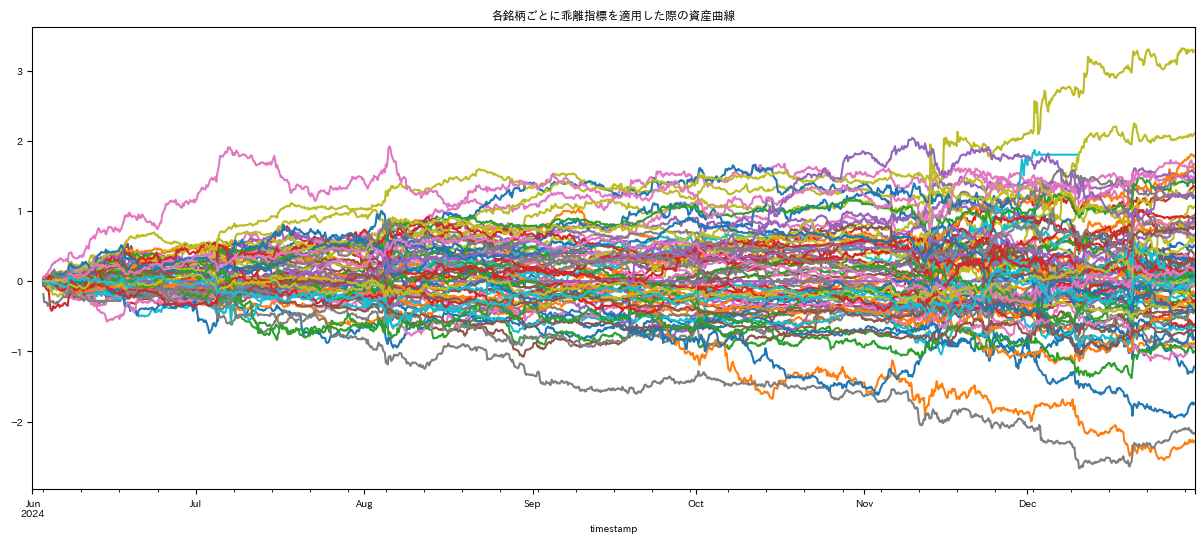

In [24]:
plt.figure(figsize=(15, 6))
for symbol, df in df_dict.items():
    try:
        tmp = df.copy()
        tmp['signal'] = -np.sign(tmp[f'{symbol}_dev_stdz_s1'])
        (tmp['signal'] * tmp[f'{symbol}_perp_ror']).cumsum().plot()
    except:
        print(f'{symbol}: データ不足でプロットできず')
plt.title('各銘柄ごとに乖離指標を適用した際の資産曲線')
plt.show()

# クロスセクションを試す

- 全銘柄のDataFrameを結合する

In [20]:
df_all = pd.concat(df_dict.values(), axis=1)
df_all

,ZROUSDT_dev_stdz_s1,ZROUSDT_perp_ror,GMTUSDT_dev_stdz_s1,GMTUSDT_perp_ror,NEARUSDT_dev_stdz_s1,NEARUSDT_perp_ror,JTOUSDT_dev_stdz_s1,JTOUSDT_perp_ror,DOGEUSDT_dev_stdz_s1,DOGEUSDT_perp_ror,...,LINKUSDT_dev_stdz_s1,LINKUSDT_perp_ror,WAVESUSDT_dev_stdz_s1,WAVESUSDT_perp_ror,SOLUSDT_dev_stdz_s1,SOLUSDT_perp_ror,ARBUSDT_dev_stdz_s1,ARBUSDT_perp_ror,PHAUSDT_dev_stdz_s1,PHAUSDT_perp_ror
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-06-01 00:00:00+00:00,NaN,NaN,NaN,0.012853,NaN,-0.003310,NaN,0.010369,NaN,0.003080,...,NaN,-0.004180,NaN,-0.004803,NaN,0.008277,NaN,0.007768,NaN,NaN
2024-06-01 04:00:00+00:00,NaN,NaN,NaN,-0.005922,NaN,-0.002906,NaN,0.004354,NaN,-0.002820,...,NaN,0.009921,NaN,-0.005791,NaN,-0.001035,NaN,-0.004873,NaN,NaN
2024-06-01 08:00:00+00:00,NaN,NaN,NaN,0.003404,NaN,0.003470,NaN,-0.015032,NaN,0.002513,...,NaN,0.001511,NaN,0.002997,NaN,0.000425,NaN,-0.000178,NaN,NaN
2024-06-01 12:00:00+00:00,NaN,NaN,NaN,0.000000,NaN,0.007469,NaN,0.012518,NaN,0.004011,...,NaN,0.002910,NaN,0.001726,NaN,0.002047,NaN,0.004630,NaN,NaN
2024-06-01 16:00:00+00:00,NaN,NaN,NaN,0.000000,NaN,0.013729,NaN,-0.002116,NaN,0.004370,...,NaN,-0.007039,NaN,-0.003151,NaN,0.001063,NaN,0.000620,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 04:00:00+00:00,0.608386,0.002822,1.119110,-0.012092,-0.868519,0.007677,1.113660,-0.013801,-0.202245,0.002216,...,1.755640,0.002270,NaN,0.000000,-1.210008,0.000632,-0.366667,0.003058,NaN,-0.039242
2024-12-31 08:00:00+00:00,0.000318,0.022893,0.518115,0.018359,-0.115203,0.008018,0.742589,0.006106,-0.268678,0.024416,...,0.074310,0.010733,NaN,0.000000,-1.110181,0.019900,-0.293940,0.020371,NaN,-0.116883
2024-12-31 12:00:00+00:00,1.064211,0.028872,-0.095167,0.002941,0.729727,0.015709,-0.719292,0.039670,0.782506,0.024177,...,-0.220695,0.013296,NaN,0.000000,1.360078,0.023537,-0.756035,0.011543,NaN,0.050826


- ある時点における、指標の上位3つをショート（逆張り指標のため）、下位3つをロング

100% 1284/1284 [00:00<00:00, 7178.88it/s]


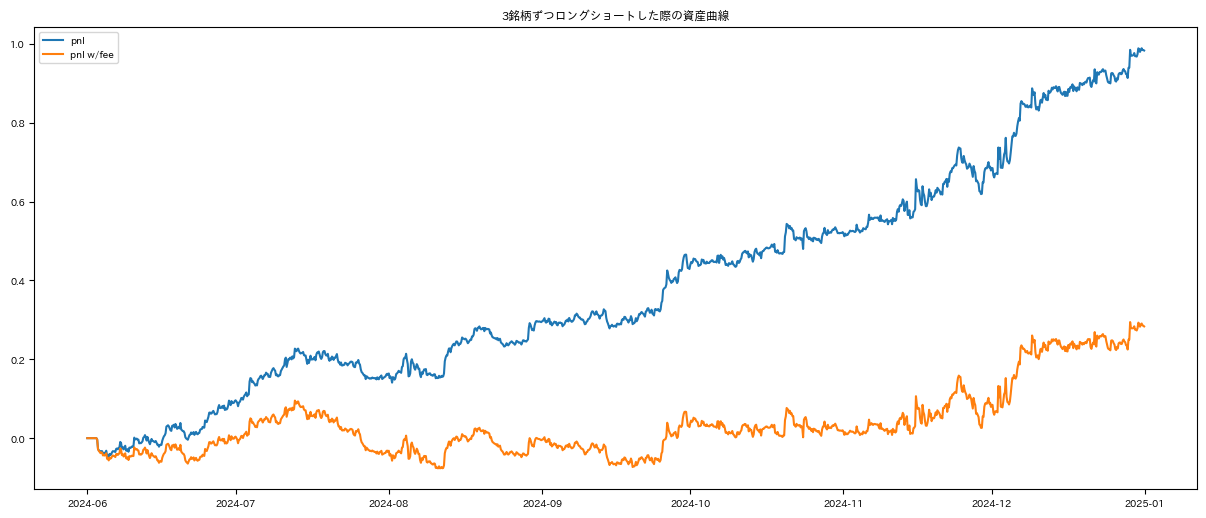

In [22]:
symbol_num = 3
pnl_array = []
pnl_fee_array = []
pre_min_symbols = []
pre_max_symbols = []
for row in tqdm(df_all.values):
    row = dict(zip(df_all.columns, row))
    # {銘柄名: 指標}のdictを作成して昇順ソートする.
    indicators = {symbol: row[f'{symbol}_dev_stdz_s1'] for symbol in large_usdt_symbols if not np.isnan(row[f'{symbol}_dev_stdz_s1'])}
    indicators_sorted = dict(sorted(indicators.items(), key=lambda x:x[1]))
    # 下位銘柄
    min_symbols = list(indicators_sorted.keys())[:symbol_num]
    # 上位銘柄
    max_symbols = list(indicators_sorted.keys())[-symbol_num:]
    pnl = 0
    fee = 0
    # 下位銘柄をロング（PnLを加える）
    for symbol in min_symbols:
        pnl += row[f'{symbol}_perp_ror']
        if symbol not in pre_min_symbols:
            fee += 0.0006 / (symbol_num*2)
    # 上位銘柄をショート（PnLのマイナスを加える）
    for symbol in max_symbols:
        pnl -= row[f'{symbol}_perp_ror']
        if symbol not in pre_max_symbols:
            fee += 0.0006 / (symbol_num*2)
    pre_min_symbols = min_symbols
    pre_max_symbols = max_symbols
    pnl_array.append(pnl / (symbol_num*2))
    pnl_fee_array.append(pnl / (symbol_num*2) - fee)
    
plt.figure(figsize=(15, 6))
plt.title(f'{symbol_num}銘柄ずつロングショートした際の資産曲線')
plt.plot(df_all.index.values, np.array(pnl_array).cumsum(), label='pnl')
plt.plot(df_all.index.values, np.array(pnl_fee_array).cumsum(), label='pnl w/fee')
plt.legend()
plt.show()

# 知見とまとめ

- クロスセクション戦略について
  - 暗号資産はアルトコインが多数存在するため、普遍的な指標はクロスセクション方向に展開できる。
  - その相対的な強弱によってロングショート戦略などを構築できる。ただし指標の標準化は必要。
- 今回使った指標について
  - よさそうな損益曲線は出ているが、筆者が検証した限りはさほど安定しない。
    - コストを入れるとこのまま実運用は厳しい。
    - 利用する銘柄や標準化期間などで損益曲線が乱れるケースが見受けられた。なので、今回の結果はあくまでクロスセクション戦略の一例として参考程度に利用すること。


# 次回以降の勉強会について

- コンテンツとYouTube Liveと親和性が微妙
  - notebook自体は勉強用コンテンツとして良さそうだが、手抜きしてそれをYouTube配信時の資料としてそのまま使ってるのがよくないかも
  - 第一期の勉強会は今回で終了とし、ここまでの内容はnoteやzennとかにまとめておきたい
- いま、LLMを利用して効率よくコンテンツや資料を作る方法を模索中なので、形式を変えて第二期を始めるか、別のシリーズを始める予定です。